# Tutorial 0.1: StrictJSON Multimodal Inputs
- Created: 8 Mar 2025
- Add in a decorator for the llm function to enable multimodal (image + text) inputs for OpenAI and Gemini models (examples for more models to come!)
- Shows how to interface OpenAI with multimodal inputs like images and text
- Just wrap the multimodal input as a http:// url or the file name, e.g. `<<image.jpg>>`, `<<https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg>>`

In [1]:
from dotenv import load_dotenv
# put your secret keys in your .env
# For instance, if you are using OpenAI, your .env should contain
# export OPENAI_API_KEY = "sk-......."
load_dotenv()

True

In [2]:
# !pip install strictjson

In [3]:
from strictjson import strict_json

# OpenAI Multimodal LLM parsing

In [4]:
# !pip install openai

In [5]:
import os
import re
import base64
import mimetypes

def replace_image_marker(func):
    """
    A decorator that scans the user prompt for markers in the form <<marker>>.
    For each marker:
      - If it is a URL (i.e. starts with "http://" or "https://"), it is replaced
        with an image dictionary in the OpenAI expected format.
      - If the marker corresponds to a local image file (exists in the current directory),
        it is read, encoded in Base64, and converted into a data URL.
      - All non-marker text is wrapped as a text part.
    The resulting list (mixing text and image dictionaries) is passed to the wrapped function.
    """
    def wrapper(system_prompt: str, user_prompt: str):
        if '<<' in user_prompt and '>>' in user_prompt:
            # Split by markers; odd-indexed parts are markers.
            parts = re.split(r'<<(.*?)>>', user_prompt)
            new_contents = []
            for idx, part in enumerate(parts):
                if idx % 2 == 1:
                    marker = part.strip()
                    if marker.startswith("http://") or marker.startswith("https://"):
                        new_contents.append({"type": "image_url", "image_url": {"url": marker}})
                    elif os.path.isfile(marker):
                        # Get MIME type based on file extension
                        mime_type, _ = mimetypes.guess_type(marker)
                        if mime_type is None:
                            mime_type = "application/octet-stream"
                        # Encode the image in Base64
                        with open(marker, "rb") as f:
                            encoded = base64.b64encode(f.read()).decode("utf-8")
                        data_url = f"data:{mime_type};base64,{encoded}"
                        new_contents.append({"type": "image_url", "image_url": {"url": data_url}})
                    else:
                        # If marker is not a URL or valid file, treat it as literal text.
                        new_contents.append({"type": "text", "text": f"<<{marker}>>"})
                else:
                    if part:
                        new_contents.append({"type": "text", "text": part})
            return func(system_prompt, new_contents)
        else:
            # If no markers, wrap the entire prompt as text.
            return func(system_prompt, [{"type": "text", "text": user_prompt}])
    return wrapper

@replace_image_marker
def openai(system_prompt: str, user_prompt):
    """
    Calls the OpenAI API.

    The processed `user_prompt` (a list of dictionaries mixing text and image_url types)
    is passed as the content of the user message. Optionally, a system message is also included.
    """
    from openai import OpenAI

    client = OpenAI()

    messages = []
    if system_prompt:
        messages.append({
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        })
    messages.append({
        "role": "user",
        "content": user_prompt
    })

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    return response.choices[0].message.content


# Gemini Multimodal LLM Parsing

In [6]:
# !pip install google-genai

In [7]:
def replace_image_marker_gemini(func):
    """
    A decorator that scans the user prompt for markers in the form <<filename>>.
    For each marker, it attempts to load an image either from a local file (e.g., .png, .jpg, etc.)
    or from an HTTP URL, and replaces the marker with the corresponding image object.
    Local images are loaded via PIL.Image, while HTTP images are fetched using requests
    and wrapped as a types.Part for the Gemini API.
    The resulting list (mixing text and images) is passed to the wrapped function.
    """
    def wrapper(system_prompt: str, user_prompt: str):
        import re
        parts = re.split(r'<<(.*?)>>', user_prompt)
        new_contents = []
        for idx, part in enumerate(parts):
            if idx % 2 == 1:
                image_source = part.strip()
                # Check if the marker is an HTTP(S) URL.
                if image_source.startswith("http://") or image_source.startswith("https://"):
                    try:
                        import requests
                        response = requests.get(image_source)
                        response.raise_for_status()
                        from google.genai import types
                        # Try to get the MIME type from the response headers; default to image/jpeg.
                        mime_type = response.headers.get("Content-Type", "image/jpeg")
                        new_contents.append(types.Part.from_bytes(data=response.content, mime_type=mime_type))
                    except Exception as e:
                        # If fetching the image fails, leave the marker as text.
                        new_contents.append(f"<<{part}>>")
                else:
                    try:
                        from PIL import Image
                        image = Image.open(image_source)
                        new_contents.append(image)
                    except Exception as e:
                        new_contents.append(f"<<{part}>>")
            else:
                if part:
                    new_contents.append(part)
        return func(system_prompt, new_contents)
    return wrapper

@replace_image_marker_gemini
def gemini(system_prompt: str, user_prompt):
    """
    Calls the Gemini API. If the user_prompt has been processed into a list (via our decorator),
    it is used directly as the contents; otherwise, the user_prompt is wrapped in a list.
    """
    from google.genai import types
    from google import genai
    import os

    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

    # Use the user_prompt directly if it's a list, otherwise wrap it.
    contents = user_prompt if isinstance(user_prompt, list) else [user_prompt]

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(system_instruction=system_prompt, temperature=0),
        contents=contents
    )
    return response.text

# Process Images + Text

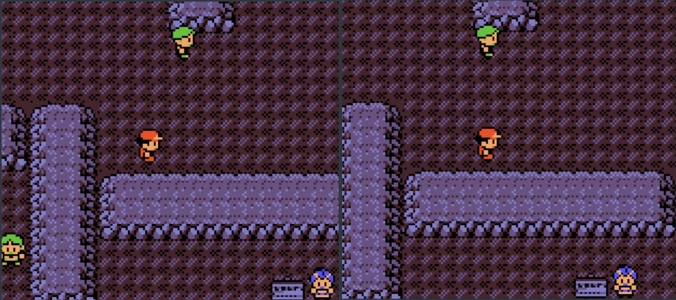

In [8]:
from PIL import Image
from IPython.display import display
import requests
from io import BytesIO

def open_image(source):
    """
    Opens an image from a URL or a local file path.
    If source is a URL, fetches the image using requests.
    """
    if source.startswith("http://") or source.startswith("https://"):
        response = requests.get(source)
        response.raise_for_status()  # Raise an exception for HTTP errors.
        return Image.open(BytesIO(response.content))
    else:
        return Image.open(source)

# Open the images using the helper function.
image1 = open_image("https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map1.png?raw=true")
image2 = open_image("https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map2.png?raw=true")

# Optionally resize both images to a common max height while preserving aspect ratio.
max_height = 300
image1.thumbnail((image1.width, max_height))
image2.thumbnail((image2.width, max_height))

# Get the sizes of the resized images.
width1, height1 = image1.size
width2, height2 = image2.size

# Create a new image with a width that is the sum of both images and a height equal to the max of the two heights.
new_width = width1 + width2
new_height = max(height1, height2)
new_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))  # white background

# Paste the images side by side.
new_image.paste(image1, (0, 0))
new_image.paste(image2, (width1, 0))

# Display the concatenated image.
display(new_image)

In [9]:
# See OpenAI's processing abilities
res = strict_json('''You are a friendly assistant to play a game for the player. 
You are to describe what happened in previous game states''',
      "Previous state 1: <<https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map1.png?raw=true>>, state 2: <<https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map2.png?raw=true>>",
      output_format = {"State 1": "Describe first state",
                      "State 2": "Describe second state",
                      "Thoughts": "Describe what has happened"},
      llm = openai)

In [10]:
res

{'State 1': 'The character is navigating through a cavern-like area, moving along a path with two paths diverging, while two NPCs are visible in the vicinity, one above and another character to the left.',
 'State 2': 'The character continues to walk through the same cavernous environment, remaining on the path, with the same two NPCs present, one above and another to the left, indicating no significant changes in surroundings.',
 'Thoughts': "The character seems to be exploring the environment while interacting with NPCs, indicating a focus on navigation within the game world, but there hasn't been any notable progress in the last two states."}

In [11]:
# See Gemini's processing abilities
res = strict_json('''You are a friendly assistant to play a game for the player. 
You are to describe what happened in previous game states''',
      "Previous state 1: <<https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map1.png?raw=true>>, state 2: <<https://github.com/tanchongmin/agentjo/blob/main/projects/Pokemon/Game/map2.png?raw=true>>",
      output_format = {"State 1": "Describe first state",
                      "State 2": "Describe second state",
                      "Thoughts": "Describe what has happened"},
      llm = gemini)

In [12]:
res

{'State 1': 'The player character is in a cave with other trainers. The player is standing on a ledge.',
 'State 2': 'The player character is in a cave with other trainers. The player is standing on a ledge. The trainer in the bottom left is no longer there.',
 'Thoughts': 'The player has moved slightly to the right. The trainer in the bottom left has moved away.'}